In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras import layers,models
%matplotlib inline
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPool2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.preprocessing.image import ImageDataGenerator
import warnings

In [2]:
import os

In [3]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
EPOCHS = 50
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "../input/indian-food-classification/Food Classification",
    shuffle = True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE )

Found 6269 files belonging to 20 classes.


In [4]:
class_names = dataset.class_names
class_names

['burger',
 'butter_naan',
 'chai',
 'chapati',
 'chole_bhature',
 'dal_makhani',
 'dhokla',
 'fried_rice',
 'idli',
 'jalebi',
 'kaathi_rolls',
 'kadai_paneer',
 'kulfi',
 'masala_dosa',
 'momos',
 'paani_puri',
 'pakode',
 'pav_bhaji',
 'pizza',
 'samosa']

In [5]:
len(dataset)

196

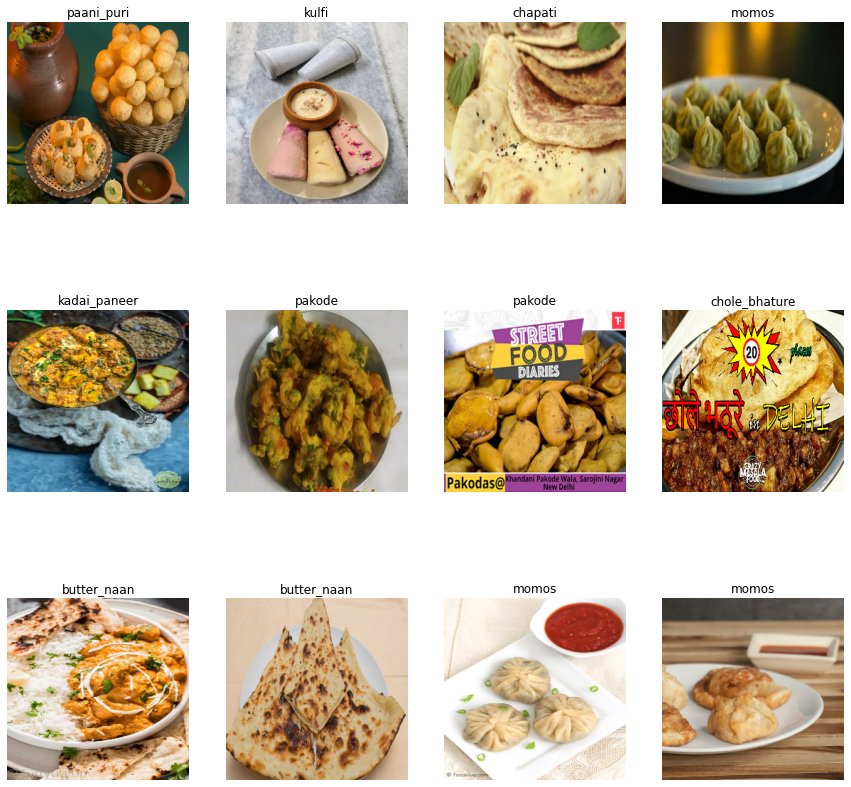

In [6]:
plt.figure(figsize = (15,15))
for image_batch,label_batch in dataset.take(1):
    for i in range(12):
        a = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch[i]])
        plt.axis('off')

In [7]:
def get_dataset_partitions_tf(ds,train_split = 0.8,test_split = 0.1,val_split = 0.1,shuffle = True,shuffle_size = 10000):
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size,seed = 12)
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    return train_ds,test_ds,val_ds


In [8]:
train_ds , test_ds, val_ds = get_dataset_partitions_tf(dataset)

In [9]:
len(train_ds)

156

In [10]:
len(test_ds)

21

In [11]:
len(val_ds)

19

In [12]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.experimental.AUTOTUNE)
test_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.experimental.AUTOTUNE)
val_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.experimental.AUTOTUNE)

In [13]:
resize_and_rescale = tf.keras.Sequential([
        layers.experimental.preprocessing.Resizing(256,256),
        layers.experimental.preprocessing.Rescaling(1.0/255)
    ])

In [14]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [15]:
input_shape = (32,256,256,3)
n_classes = len(class_names)
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32,(3,3),activation = 'relu',input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(128,(3,3),activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(256,activation = 'relu'),
    layers.Dense(n_classes,activation = 'softmax'),
])
model.build(input_shape = input_shape)

In [16]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (32, 256, 256, 3)         0         
_________________________________________________________________
sequential_1 (Sequential)    (32, 256, 256, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (32, 254, 254, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (32, 127, 127, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (32, 125, 125, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (32, 62, 62, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (32, 60, 60, 64)         

In [17]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
    metrics = ['accuracy']
)

In [18]:
history = model.fit(
    train_ds,
    epochs = 200,
    batch_size = BATCH_SIZE,
    verbose = 1,
    validation_data = val_ds)

Epoch 1/200
156/156 [==============================] - 110s 52ms/step - loss: 2.7606 - accuracy: 0.1343 - val_loss: 2.6700 - val_accuracy: 0.1475
Epoch 2/200
156/156 [==============================] - 8s 50ms/step - loss: 2.5422 - accuracy: 0.1928 - val_loss: 2.5013 - val_accuracy: 0.2337
Epoch 3/200
156/156 [==============================] - 8s 49ms/step - loss: 2.3812 - accuracy: 0.2518 - val_loss: 2.1820 - val_accuracy: 0.3209
Epoch 4/200
156/156 [==============================] - 8s 49ms/step - loss: 2.2406 - accuracy: 0.3107 - val_loss: 2.1276 - val_accuracy: 0.3345
Epoch 5/200
156/156 [==============================] - 8s 49ms/step - loss: 2.1138 - accuracy: 0.3430 - val_loss: 2.0428 - val_accuracy: 0.3860
Epoch 6/200
156/156 [==============================] - 8s 50ms/step - loss: 1.9945 - accuracy: 0.3850 - val_loss: 1.8631 - val_accuracy: 0.4241
Epoch 7/200
156/156 [==============================] - 8s 49ms/step - loss: 1.8606 - accuracy: 0.4354 - val_loss: 1.7425 - val_accurac

In [19]:
scores = model.evaluate(test_ds)

156/156 [==============================] - 2s 14ms/step - loss: 0.1138 - accuracy: 0.9671


In [20]:
scores

[0.11375259608030319, 0.9671276807785034]

In [21]:
history.params

{'verbose': 1, 'epochs': 200, 'steps': 156}

In [22]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

First Image to Predict:
Actual Label: samosa
Predicted Label: samosa


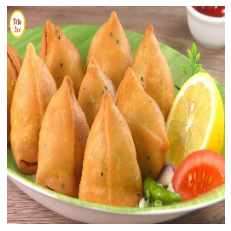

In [24]:
import numpy as np
for image_batch,label_batch in test_ds.take(1):
    first_image = image_batch[0].numpy().astype('uint8')
    first_label = label_batch[0].numpy()
    
    print("First Image to Predict:")
    plt.imshow(first_image)
    plt.axis("off")
    print("Actual Label:",class_names[first_label])
    
    batch_prediction = model.predict(image_batch)
    print("Predicted Label:",class_names[np.argmax(batch_prediction[0])])

In [25]:
import os
model.save("/kaggle/working/FoodCNN.h5")